# Анализируем полученные данные. Строим графики, предсказываем вакансии...

In [785]:
import pickle
from collections import *
import collections
import numpy as np
import networkx as nx
from tqdm import tqdm
import json
from typing import List, Tuple, Sequence
import pickle
from tqdm import tqdm_notebook as tqdm
import pymorphy2
import nltk
from cytoolz import pipe
from collections import Counter
import re
import theano
from collections import defaultdict
from collections import Counter

In [1442]:
# 04:10 утра 15 января, отключаем ворнинги
import warnings
warnings.filterwarnings("ignore")

Такие же функции, что и в data_parse, ничего интересного

In [786]:
morph = pymorphy2.MorphAnalyzer()
stopwords = nltk.corpus.stopwords.words(
    'russian') + nltk.corpus.stopwords.words('english')
stopwords += [
    'отличный', 'метр', 'наш', 'клиент', 'банка', 'проект', 'литр',
    'желательный', 'др', 'самый', 'мочь', 'хороший', 'год', 'чел', 'обязательный', 'опыт', 'работа',
    'качества', 'работа', 'свои'
]

cache = {}


def remove_numbers(text):
    return re.sub(r'\d+', '', text)


def _get_POS(word):
    if word not in cache:
        cache[word] = morph.parse(word)[0]
    return cache[word].tag.POS


def normal_form(word):
    if word not in cache:
        cache[word] = morph.parse(word)[0]
    return cache[word].normal_form


def is_word_pos_in(word: str, pos: List[str] = None) -> bool:
    if not pos:
        pos = ['NOUN', "ADJF", 'INFN', 'VERB', 'ADJS']

    return _get_POS(word) in pos


def get_words(text):
    return re.findall(r'\w+', text)


def nonempty(x):
    if isinstance(x, Sequence):
        return filter(lambda x: len(x) > 0 and x != ' ', x)
    return x


helper = {}


def remove_numbers(text):
    return re.sub(r'\d+', '', text)


def normalize_skill(skill: str):
    parsed = tuple(
        pipe(
            skill,
            lambda x: x.lower(),
            remove_numbers,
            get_words,
        ))

    clear_skill = []
    dirty_skill = []

    # Последнее стоп слово для dirty_skill
    last_stopword = None

    # Для каждого слова в скилле
    for i in parsed:
        # Нормализуем слово
        word = normal_form(i)

        # Если стоп слово - запомним его
        if word in nltk.corpus.stopwords.words('russian'):
            last_stopword = word

            if word == "без":
                clear_skill.append(word)

        # Проверим на часть речи, длинну и стоплова
        elif is_word_pos_in(word) and len(word) > 3 and word not in stopwords:

            # Если до этого было стоп слово, добавим его в dirty
            if last_stopword and len(dirty_skill) > 0:
                dirty_skill.append(last_stopword)
                last_stopword = None

            # Добавим в чистый скилл слово
            clear_skill.append(word)

            if is_word_pos_in(word, ['NOUN', 'ADJF']):
                dirty_skill.append(i)

    if len(dirty_skill) > 2 and len(dirty_skill) < 8:
        return clear_skill, dirty_skill

    else:
        return []

In [2]:
sim_to_work = pickle.load(open("sim_to_work.pck", "rb"))

In [3]:
vacancy_by_name = pickle.load(open("vacancy_by_name.pck", "rb"))

In [25]:
vacancy_by_name['e93e7dc6aac1811f5d9e0e872665f74b6d1e9c02']

{'candidat': 'Опыт работы от 3 лет, Знание складской и транспортной логистики,\nуверенный пользователь ПК, 1С\nЖелательно проживание в районе МО, г. Одинцово',
 'clear_skills': ['опыт работа',
  'знание транспортный логистика',
  'знание складской',
  'уверенный пользователь',
  'проживание район'],
 'dirty_skills': ['опыт работы',
  'знание транспортной логистики',
  'знание складской',
  'уверенный пользователь',
  'проживание в районе'],
 'drive_license': '',
 'education_value': 'неполное высшее',
 'employer_type_value': 'прямой работодатель',
 'experience_value': 'от 3 до 6 лет',
 'id': 'e93e7dc6aac1811f5d9e0e872665f74b6d1e9c02',
 'id_client': 'b2fe7d405fb9e1ab3f06656c244e163def331c75',
 'languages': [],
 'metro': [],
 'payment_from': 45000,
 'payment_to': 0,
 'place_of_work_value': 'на территории работодателя',
 'profession': 'Кладовщик',
 'profession_tree_id': 301,
 'profession_tree_name': 'Кладовщик',
 'town': 'Москва',
 'type_of_work_value': 'полный рабочий день',
 'vac': array

In [7]:
resume = pickle.load(open("resume_with_days.pkl", "rb"))

In [187]:
skills_by_theme = collections.defaultdict(lambda: [])

for vac in vacancy_by_name:
    vac = vacancy_by_name[vac]
    skills_by_theme[vac['profession_tree_name']].extend(vac['dirty_skills'])

In [67]:
for theme in skills_by_theme:
    skills_by_theme[theme] = [i[0][0] for i in collections.Counter(skills_by_theme[theme]).most_common(6000)]

In [68]:
def get_jobs(resume_id):
    '''Отсортируем работы по времени. 1999, 2000, 2010'''
    ans = {}
    for job in resume[resume_id]['work_history']:
        ans[int(job['monthbeg'])/12 + int(job['yearbeg'])] = job
    return dict(collections.OrderedDict(sorted(ans.items())))

In [ ]:
sim_to_work[]

In [104]:
an = pickle.load(open("tmp.pck", "rb"))

In [1458]:
skills_by_theme = collections.defaultdict(lambda: [])

for vac in vacancy_by_name:
    vac = vacancy_by_name[vac]
    skills_by_theme[vac['profession_tree_name']].extend(vac['clear_skills'])

In [1459]:
for skill in skills_by_theme:
    skills_by_theme[skill] = Counter(skills_by_theme[skill]).most_common(10)

In [1462]:
def get_skills(_id):
    '''Вытаскиваем навыки данной работы'''
    if _id in sim_to_work:
        sim = sim_to_work[_id]
        work = vacancy_by_name[sim[0][0]]['profession_tree_name']
        print("Название работы:", work)
        return skills_by_theme[work]
    else:
        return [[None]]

# Пошагово посмотрим на то, как добавляются навыки
Посмотрим на навыки, которые добавляются с каждой вакансией и на название вакансии...

In [1461]:
user = 0
now = get_jobs(user)
old_skills = set()

for key in now.keys():
    tmp = set([i[0] for i in get_skills(now[key]['id'])])
    tmp -= old_skills
    old_skills |= tmp
                     
    print("Новые навыки:", tmp, end="\n\n")
    
print("Итоговые скиллы:")
print(old_skills)

Промоутер
Новые навыки {'желание работать', 'желание общаться человек', 'приятный внешность', 'позитивный настрой', 'желание зарабатывать', 'умение общаться', 'грамотный речь', 'опрятный внешний', 'коммуникативный навык', 'активный жизненный позиция'}

Кладовщик
Новые навыки {'образование среднее специальный', 'опыт работа склад', 'знание программа', 'умение работать команда', 'уверенный пользователь', 'опыт работа аналогичный должность', 'опыт работа кладовщик', 'опыт работа аналогичный', 'опыт работа'}

Торговый представитель
Новые навыки {'опыт работа торговый представитель', 'опыт работа продажа', 'нацеленность результат', 'наличие автомобиль', 'наличие личный автомобиль', 'водительский право категория'}

Экономист аналитик
Новые навыки {'аналитический склад', 'сводный таблица', 'высокий экономический образование', 'опыт работа экономист', 'высокий образование', 'высокий образование экономический'}

Финансовый директор
Новые навыки {'знание законодательный', 'без вредный привычка',

In [311]:
def career(jobs):
    '''Текущая карьера по работе'''
    jobs = get_jobs(jobs)
    ans = list()
    for key in jobs:
        _id = jobs[key]['id']
        if _id in sim_to_work:
            ans.append(vacancy_by_name[sim_to_work[_id][0][0]]['profession_tree_name'])
            
    return ans

In [313]:
from joblib import delayed, Parallel

def parallel(f, data):
    """Run parallel your func on all CPU"""
    
    return Parallel(n_jobs=-1, verbose=3, max_nbytes='1G')(delayed(f)(x) for x in data)

In [314]:
data = parallel(career, range(len(resume)))

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 128945 out of 128945 | elapsed:    0.8s finished


In [317]:
data.sort(key=len)

In [474]:
normal_data = []

for i in data[::-1]:
    normal_data.append(i)

In [482]:
# Матриц
matrix = defaultdict(lambda: Counter())

for story in normal_data:
    if len(story) > 0:
        old_line = story[0]
        for line in story[1:]:
            matrix[line][old_line] += 1
            old_line = line

In [949]:
# Наш коэф. на основе того, что обычно встречается после и до tree_name
# Директор = 10
# Водитель = 3
# Промоутер = 1
k = pickle.load(open("p.pck", 'rb'))

In [637]:
answer = []

for story in normal_data:
    last_ball = 0
    cool = True
    
    if len(set(story)) > 3:
        new_story = []
        
        for line in story:
            if not last_ball > k[line]:
                new_story.append(line)
                last_ball = k[line]
    
        if cool:
            answer.append(story)

In [662]:
used = []

# Построение графа от желаемой должности

In [953]:
def get_all_ages(prof, used = None):
    '''Построение дерева до желаемой tree_name'''
    global k
    if not used:
        used = [prof]
    else:
        used.append(prof)
    
    now = []
    
    for i in matrix[prof].most_common(100):
        if i[0] not in used:

            if k[i[0]] < k[prof] and k[i[0]] + 2 >= k[prof] and k[i[0]] > 2:
                now.append(i[0])

                if len(now) == 2:
                    for j in now:
                        if prof and prof not in a:
                            a.add_node(prof)
                            
                        if j and j not in a:
                            a.add_node(j)
                            
                        if j:
                            a.add_edge(j, prof)
                        get_all_ages(j, used)
    


In [951]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

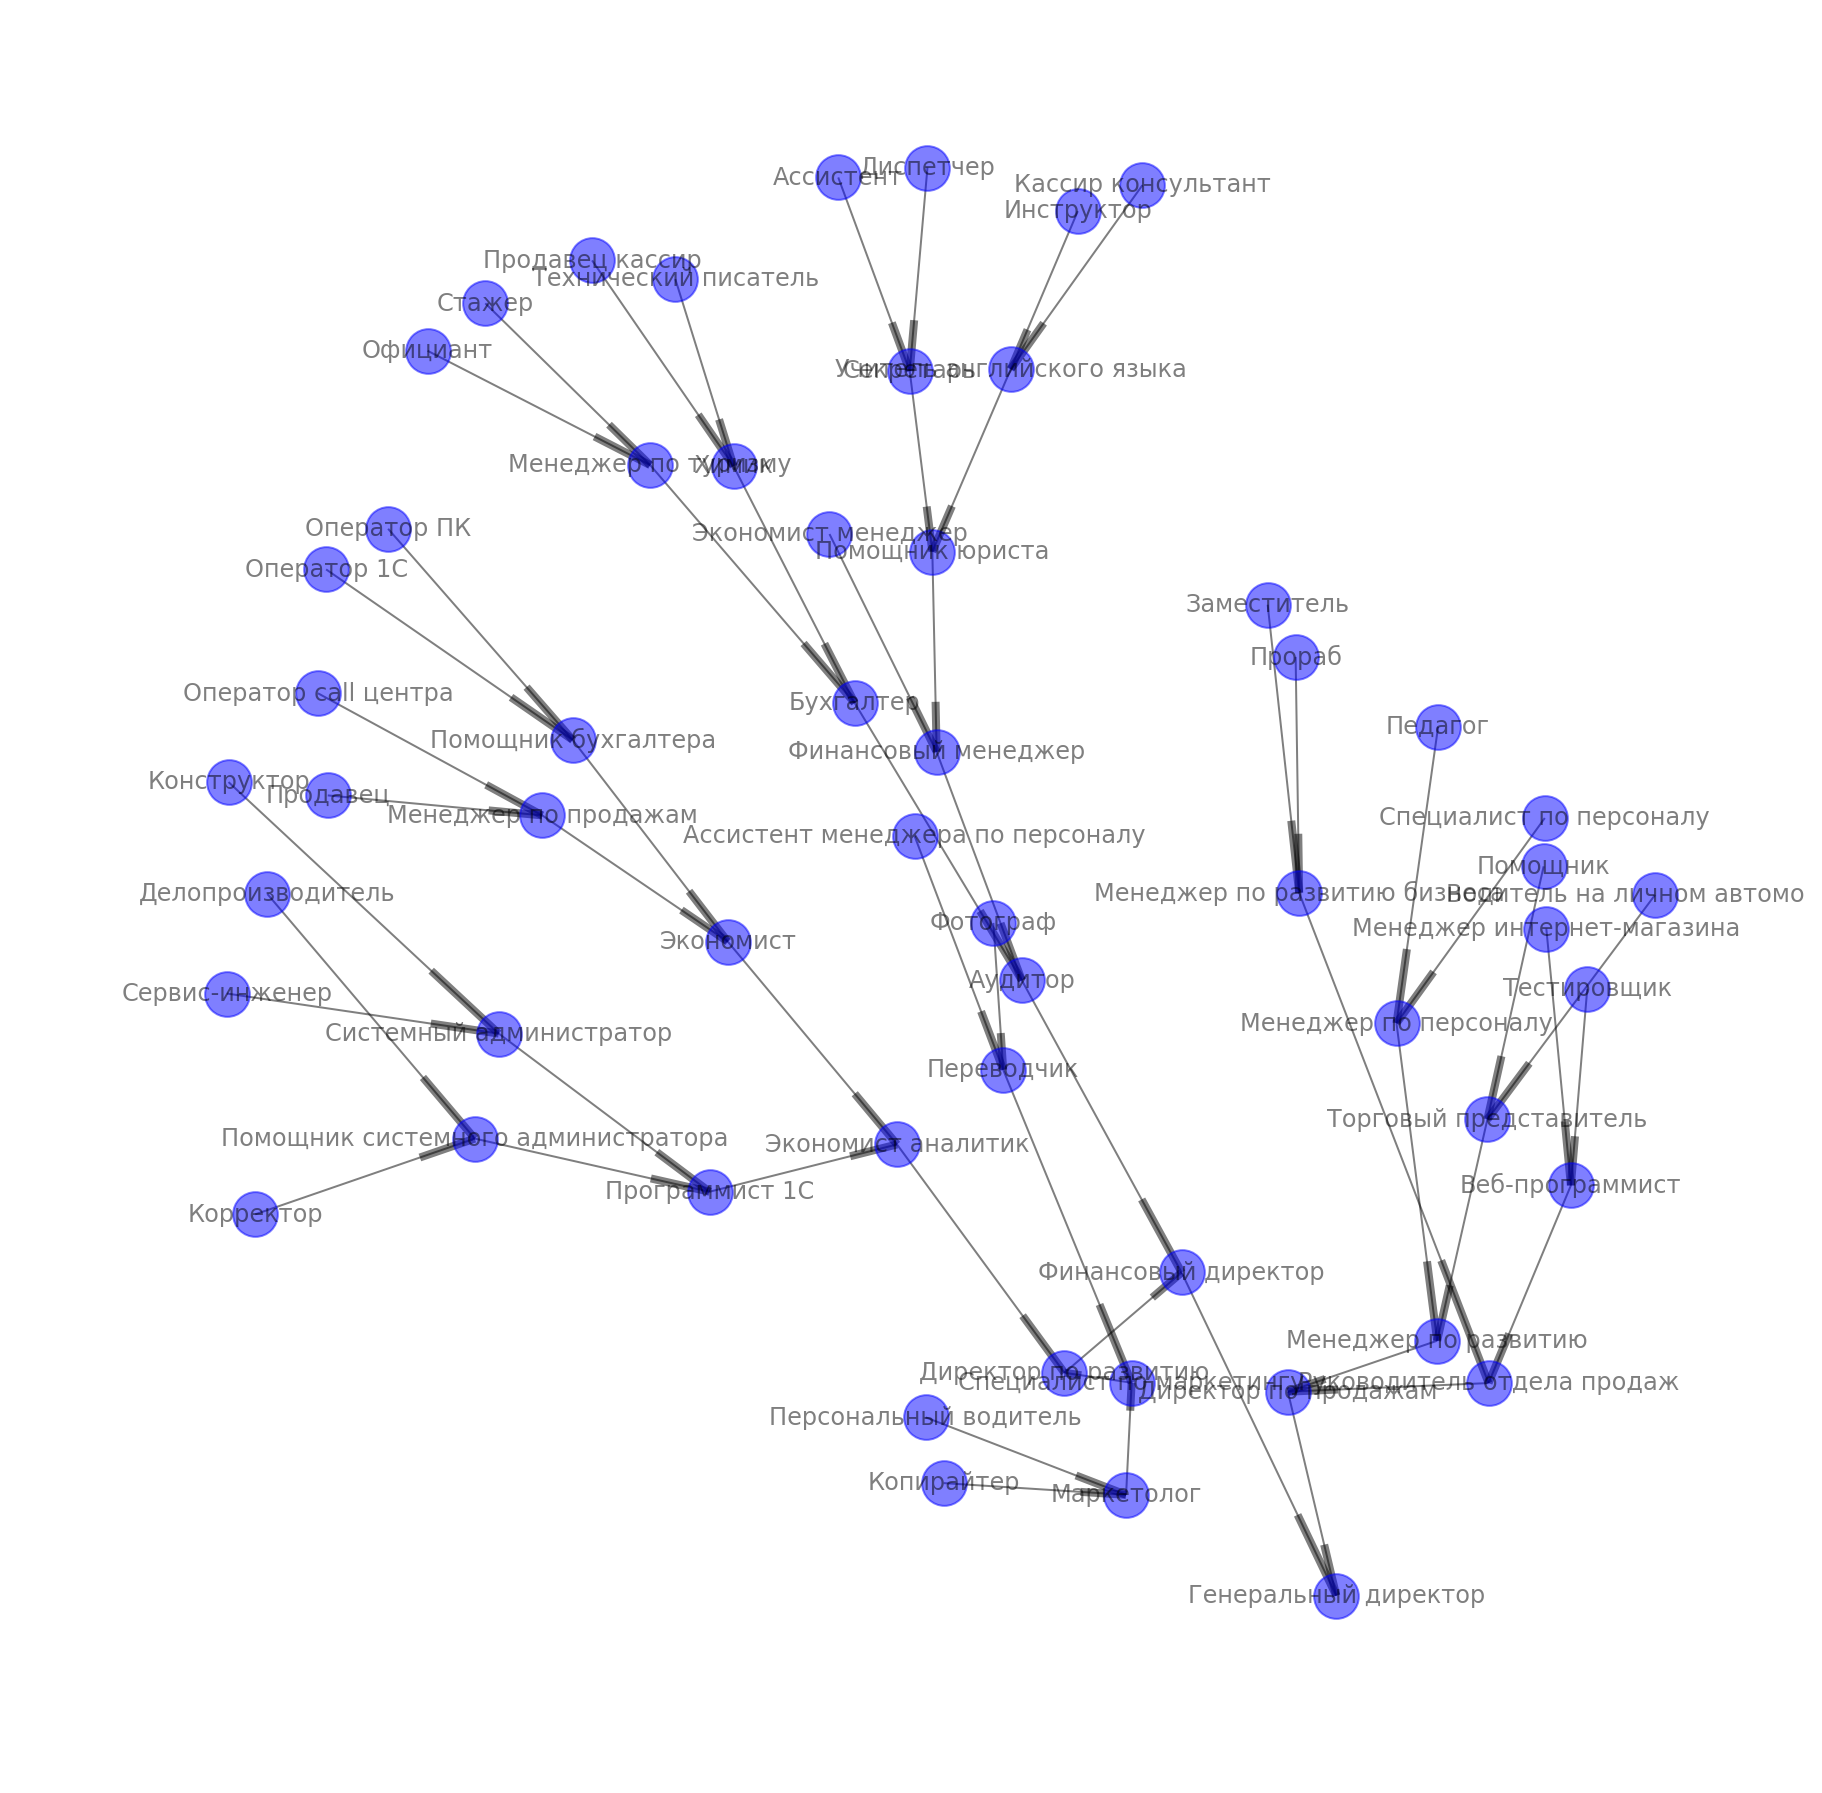

In [630]:
a = nx.DiGraph()
get_all_ages("Генеральный директор")
plt.figure(3,figsize=(12,12)) 
nx.draw(a, node_color='b', node_size=500, alpha=0.5, with_labels=True)
plt.show()

In [512]:
matrix['Генеральный директор'].most_common(1)

[('Финансовый директор', 23)]

In [498]:
matrix['Финансовый директор'].most_common(3)

[('Финансовый директор', 2402), ('Экономист аналитик', 440)]

In [500]:
matrix['Экономист аналитик'].most_common(3)

[('Экономист аналитик', 369),
 ('Финансовый директор', 347),
 ('Финансовый менеджер', 163)]

In [507]:
matrix['Финансовый менеджер'].most_common(4)

[('Финансовый менеджер', 438),
 ('Помощник бухгалтера', 294),
 ('Финансовый директор', 281),
 ('Экономист', 149)]

In [504]:
matrix['Помощник бухгалтера'].most_common(3)

[('Помощник бухгалтера', 4723), ('Бухгалтер', 1278), ('Оператор ПК', 530)]

In [505]:
matrix['Оператор ПК'].most_common(3)

[('Оператор ПК', 1199), ('Помощник бухгалтера', 466), ('Водитель', 361)]

In [492]:
Counter(k).most_common(10)

[('Генеральный директор', 10),
 ('Административный директор', 10),
 ('Директор по ИТ', 9),
 ('Руководитель', 9),
 ('Финансовый директор', 9),
 ('Директор', 9),
 ('Менеджер ВЭД', 8),
 ('Заместитель директора', 8),
 ('Технический директор', 8),
 ('Исполнительный директор', 8)]

In [355]:
pickle.dump(k, open("p.pck", "wb"))

In [469]:
normal_data

['Водитель на личном автомобиле',
 'Инженер программист',
 'Инженер программист',
 'Технический специалист',
 'Учитель русского языка и литературы',
 'Финансовый директор',
 'Инженер проектировщик',
 'Доцент',
 'Заместитель начальника отдела',
 'Аудитор',
 'Учитель русского языка и литературы',
 'Репетитор',
 'Учитель английского языка',
 'Учитель английского языка',
 'Педагог']

In [679]:
matrix['Педагог']

Counter({'Администратор': 3,
         'Администратор офиса': 2,
         'Администратор сайта': 1,
         'Администратор салона красоты': 4,
         'Аналитик': 6,
         'Ассистент менеджера по персоналу': 12,
         'Аудитор': 2,
         'Бармен': 6,
         'Библиотекарь': 14,
         'Бизнес-тренер': 4,
         'Бренд-менеджер': 1,
         'Бухгалтер': 2,
         'Веб-программист': 5,
         'Ведущий инженер конструктор': 1,
         'Водитель': 69,
         'Водитель курьер': 4,
         'Водитель на личном автомобиле': 4,
         'Водитель экспедитор': 1,
         'Главный редактор': 22,
         'Делопроизводитель': 7,
         'Дизайнер': 14,
         'Дизайнер верстальщик': 4,
         'Директор': 3,
         'Директор магазина': 2,
         'Директор по развитию': 5,
         'Доцент': 113,
         'Журналист': 64,
         'Заместитель': 10,
         'Заместитель начальника отдела': 2,
         'Заместитель руководителя отдела': 2,
         'Заместитель фина

In [762]:
themes = defaultdict(lambda: [])
dirty_to_normal = {}

for d in vacancy_by_name:
    d = vacancy_by_name[d]
    themes[d['profession_tree_name']].append(d['dirty_skills'])

In [763]:
def get_tfidf(theme):
    
    tmp = []

    for i in themes[theme]:
        tmp.extend(i)

    tf = Counter(tmp)

    for j in tf:
        tf[j] /= len(tmp)

    for word in tf:
        idf = np.log(len(themes[theme])/ sum([word in doc for doc in themes[theme]]))
        tf[word] *= idf

    return tf

In [888]:
# Все tree_name, которые есть
themes.keys()

dict_keys(['Кладовщик', 'Юрист', 'Прораб', 'Менеджер по продажам', 'Бухгалтер', 'Менеджер по работе с клиентами', 'Кассир', 'Учитель английского языка', 'Промоутер', 'Водитель экспедитор', 'Водитель', 'Инженер сметчик', 'Инженер конструктор', 'Библиотекарь', 'Мастер', 'Инженер ПТО', 'Секретарь', 'Руководитель отдела', 'Администратор сайта', 'Руководитель проекта', 'Торговый представитель', 'Инженер', 'Продавец', 'Администратор', 'Офис-менеджер', 'Менеджер по персоналу', 'Начальник участка', 'Логист', 'Региональный менеджер', 'Персональный водитель', 'Оператор call центра', 'Продавец консультант', 'Официант', 'Водитель курьер', 'Курьер', 'Переводчик', 'Продавец кассир', 'Помощник руководителя', 'Юрисконсульт', 'Заместитель главного бухгалтера', 'Охранник', 'Главный бухгалтер', 'Помощник бухгалтера', 'Специалист', 'Менеджер по туризму', 'Экономист менеджер', 'Бизнес-тренер', 'Бухгалтер экономист', 'Веб-программист', 'Менеджер', 'Директор по ИТ', 'Преподаватель', 'Инженер программист', 'С

In [967]:
# Самые чатые навыки Аудитора
get_tfidf('Аудитор').most_common(100)

[('уверенный пользователь', 0.0481534933524587),
 ('высшее образование', 0.040953887763025908),
 ('опыт работы', 0.040953887763025908),
 ('высшее экономическое образование', 0.029516103077808248),
 ('опытный пользователь', 0.029516103077808248),
 ('знание', 0.027655683380983044),
 ('права категории', 0.023534372968701825),
 ('желание в сфере мерчендайзинга', 0.023534372968701825),
 ('наличие опыта работы', 0.023534372968701825),
 ('опыт работы в аналогичной должности бухгалтерии работа с договорами',
  0.023534372968701825),
 ('умение в команде', 0.021236651193745876),
 ('высшее образование экономическое', 0.018746240149720841),
 ('желание', 0.018746240149720841),
 ('наличие диктофона и фотоаппарата', 0.018746240149720841),
 ('знание программы', 0.01734831835115062),
 ('опыт работы аудитором', 0.016024120089002034),
 ('высшее экономическое', 0.016024120089002034),
 ('опыт работы в аналогичной должности', 0.016024120089002034),
 ('аналитический склад', 0.016024120089002034),
 ('умение с

In [773]:
cahce = pickle.load(open("cahce.pck", "rb"))

In [769]:
vacancy = []

for k in vacancy_by_name:
    vacancy.append(vacancy_by_name[k])

In [777]:
def _clear(text):
    return list(filter(lambda x: x not in stopwords, get_words(remove_numbers(text.lower()))))

In [934]:
def to_vec(tupl):
    skills_vecs = []
    for skill in tupl:
        skill_vec = np.sum(list(map(lambda x: cahce[x], _clear(skill))), axis=0)
        skills_vecs.append(skill_vec)
    return np.mean(skills_vecs, axis=0)

In [935]:
len(vacancy_by_name)

190066

In [842]:
vacancy = pickle.load(open("vacancy_with_vecs.pck", "rb"))

In [929]:
themes_vectors = defaultdict(lambda: [])

In [930]:
for vac in vacancy:
    if not np.isnan(vac['vec']).all():
        themes_vectors[vac['profession_tree_name']].append(vac['vec'])

In [931]:
for theme in themes_vectors:
    themes_vectors[theme] = np.sum(themes_vectors[theme], axis=0)

In [936]:
def compile_cos_sim_theano():
    v1 = theano.tensor.vector(dtype='float32')
    v2 = theano.tensor.vector(dtype='float32')
    
    numerator = theano.tensor.sum(v1*v2)
    denominator = theano.tensor.sqrt(theano.tensor.sum(v1**2)*theano.tensor.sum(v2**2))
   
    return theano.function([v1, v2], numerator/denominator)

cos_sim_theano_fn = compile_cos_sim_theano()

In [937]:
def get_theme(tupl):
    vec = to_vec(tupl)
    a = Counter()
    
    for theme in themes_vectors:
        a[theme] = cos_sim_theano_fn(themes_vectors[theme], vec)
    return a.most_common(1)[0][0]

In [1257]:
def draw_path(theme):
    '''Всё в одном.'''
    a = nx.DiGraph()

    def get_all_ages(prof, used = None):
        global k
        if not used:
            used = [prof]
        else:
            used.append(prof)

        now = []

        for i in matrix[prof].most_common(100):
            if i[0] not in used:

                if k[i[0]] < k[prof] and k[i[0]] + 2 >= k[prof] and k[i[0]] > 2:
                    now.append(i[0])

                    if len(now) == 2:
                        for j in now:
                            if prof and prof not in a:
                                a.add_node(prof)

                            if j and j not in a:
                                a.add_node(j)

                            if j:
                                a.add_edge(j, prof)
                            get_all_ages(j, used)

    get_all_ages(theme)
    plt.figure(3,figsize=(12,12)) 
    nx.draw(a, node_color='b', node_size=500, alpha=0.5, with_labels=True)
    plt.show()

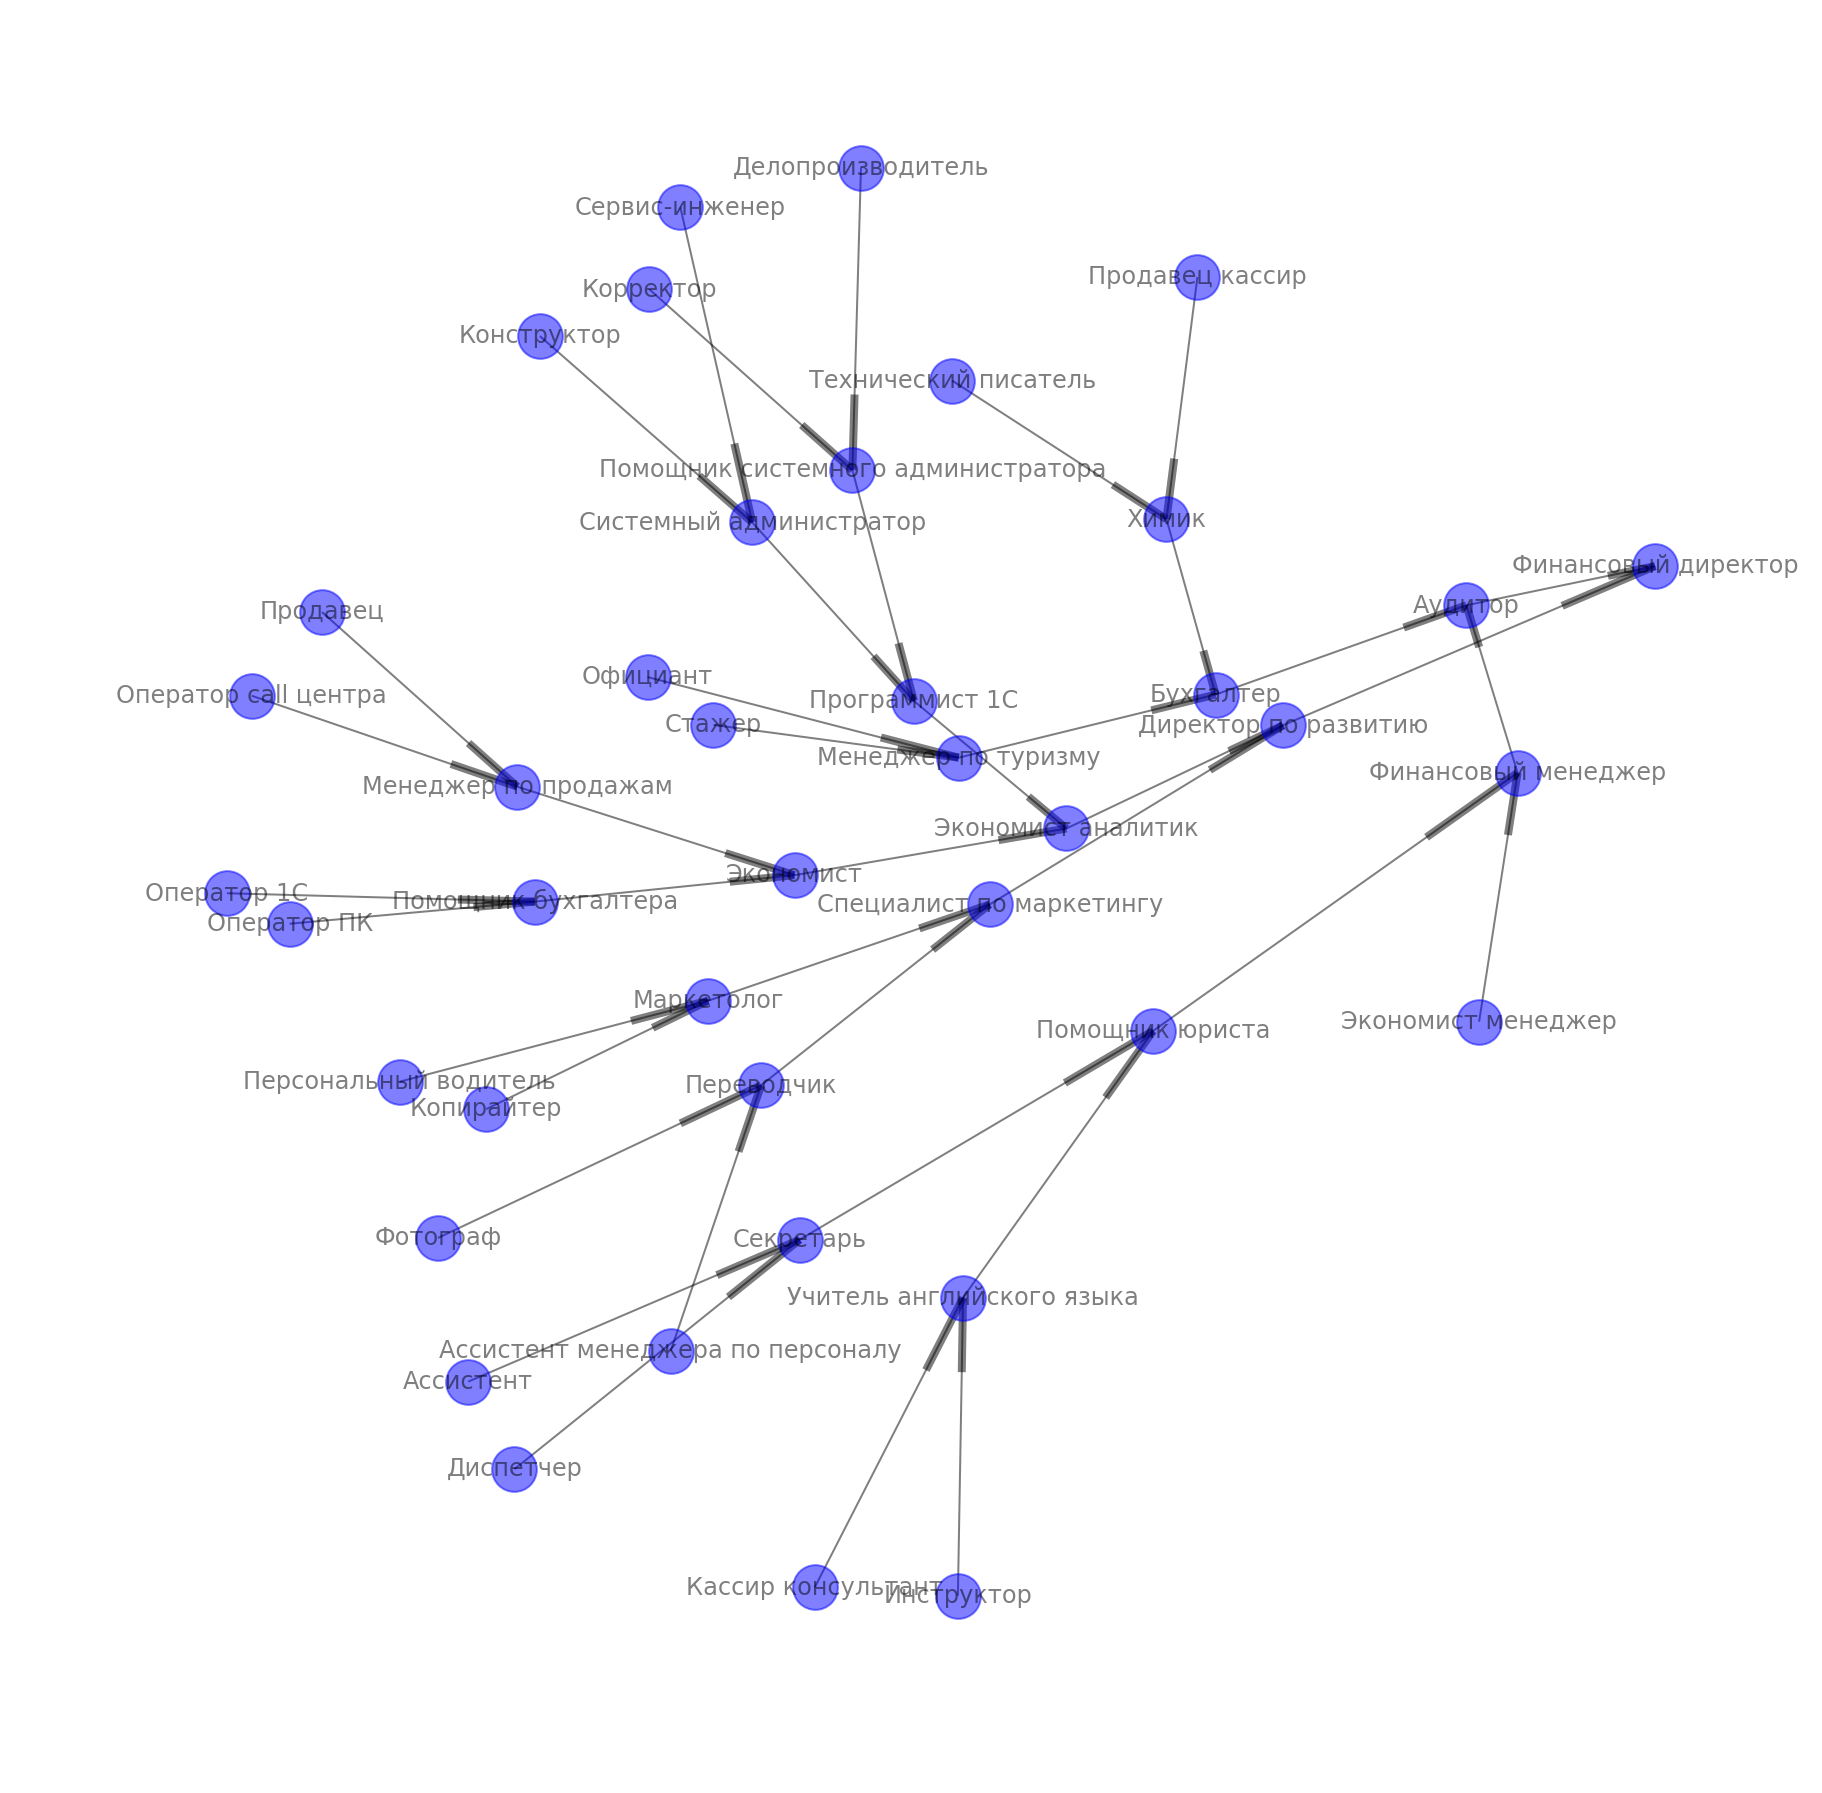

In [1258]:
draw_path("Финансовый директор")

# Построение графа до желаемой должности

In [1020]:
# matrix[i][j] - кол-во человек, которое из должности i перешли в должности j
matrix_back = defaultdict(lambda: Counter())

for line in normal_data:
    if len(line) > 1:
        first = line[0::2]
        second = line[1::2]
        
        for i in range(len(second)):
            if k[first[i]] < k[second[i]]:
                matrix_back[first[i]][second[i]] += 1

In [1080]:
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [1221]:
api_key = 'Kyxdr2dZqCwvx2yfpTvd'
import plotly
plotly.tools.set_credentials_file(username='tvorogme', api_key=api_key)

In [1238]:
matrix_back['Финансовый директор']

Counter({'Генеральный директор': 19})

In [1311]:
vacs_by_theme = defaultdict(lambda: [])

for vac in vacancy:
    vacs_by_theme[vac['profession_tree_name']].append(vac)

In [1313]:
sim_to_work = pickle.load(open("sim_to_work.pck", "rb"))

In [1324]:
for work in sim_to_work:
    if sim_to_work[work]:
        tmp = vacancy_by_name[sim_to_work[work][0][0]]

        if 'popularity' not in tmp:
            tmp['popularity'] = 0

        tmp['popularity'] += 1

In [1330]:
similar_to_theme = {}

for theme in tqdm(themes):
    cool = []
    for name in vacancy_by_name:
        tmp = vacancy_by_name[name]
        if 'popularity' in tmp and tmp['profession_tree_name'] == theme:
            cool.append([tmp['popularity'], tmp['id']])
    cool.sort(reverse=True)
    similar_to_theme[theme] = cool[:10]

A Jupyter Widget

In [1343]:
import gensim

In [1344]:
model = gensim.models.KeyedVectors.load_word2vec_format("ruwikiruscorpora_upos_cbow_300_20_2017.bin.gz", binary=True)

In [1386]:
tmp_vector = np.array([0] * 300, dtype=np.float32)

def _word2vec(word):
    for i in ["_NOUN", "_ADJ", "_VERB"]:
        tmp = "{}{}".format(word, i)
        
        if tmp in model:
            return model[tmp]
        else:
            return tmp_vector

def to_vec(tupl):
    skills_vecs = []
    for skill in tupl:
        
        skill_vec = np.asarray(list(map(lambda x: _word2vec(morph.parse(x)[0].normal_form), skill)))
        if not np.array_equal(tmp_vector, skill_vec):
            skills_vecs.append(np.mean(skill_vec, axis=0))
    return np.mean(skills_vecs, axis=0)

In [1416]:
def recommend_vac(_next, cur_skills):
    '''Рекоммендуем вакансию по скиллам'''
    current_vec = to_vec(cur_skills)
    vecs = [to_vec(vacancy_by_name[i[1]]['clear_skills']) for i in similar_to_theme[_next]]

    vecs = list(filter(lambda x: not np.isnan(x).all(), vecs))

    sim = list(map(lambda x: float(cos_sim_theano_fn(x, current_vec)), vecs))
    vacs = [vacancy_by_name[i[1]]['profession'] for i in similar_to_theme[_next]]

    return Counter({x:y for x,y in zip(vacs, sim)}).most_common(3)

In [ ]:
cur_skills = ['грамотная речь', 'самостоятельного поиска информации'] 
_next = "Редактор"

In [1431]:
[i[0] for i in recommend_vac(_next, cur_skills)]

/home/profilum/.anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning:

Mean of empty slice.



['Редактор новостной ленты', 'Творческий редактор', 'Журналист-редактор']

In [1439]:
def draw(theme, cur_skills= None):
    a = nx.DiGraph()

    def get_all_ages(prof, used=None):
        global k
        if not used:
            used = [prof]
        else:
            used.append(prof)

        now = []

        # {'Генеральный директор': 19}
        for i in matrix_back[prof].most_common():
            if i[0] not in used:  # False
                rating_next = k[i[0]]  # 10
                rating_now = k[prof]  # 9

                if rating_next > rating_now and rating_now + 2 >= rating_next:
                    now.append(i[0])

                    if len(now) > 2:
                        break
        for j in now:
            if prof and prof not in a:
                a.add_node(prof)

            if j and j not in a:
                a.add_node(j)

            if j:
                a.add_edge(prof, j)

            get_all_ages(j, used)

    get_all_ages(theme)
    p = nx.random_layout(a)

    new_p = {}
    prev_level_count = defaultdict(lambda: 0)

    for node in a.nodes():
        # (Название, x, y)

        i = [0, 0]
        i[0] = k[node] + 0.03 * prev_level_count[k[node]]
        i[1] = prev_level_count[k[node]]
        prev_level_count[k[node]] += 1
        new_p[node] = i

    p = new_p
    
    def _arrow(x, y, x2, y2):
        return dict(
            ax=x2,
            ay=y2,
            axref='x',
            ayref='y',
            x=x,
            y=y,
            xref='x',
            yref='y',
            showarrow=True,
            arrowhead=2,
            arrowsize=2,
            arrowwidth=1,
            arrowcolor='#636363'
        )
    arrows = []
    for edge in a.edges():
        x0, y0 = p[edge[0]]
        x1, y1 = p[edge[1]]

        arrows.append(_arrow(x1, y1, x0, y0))

    node_trace = Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        showlegend = True,
        marker=Marker(
            showscale=True,
            reversescale=True,
            colorscale="YIGnBu",
            color=[],
            size=20))
    x_text, y_text, labels = [], [], []
    
    for node in a.nodes():
        x, y = p[node]
        x_text.append(x)
        y_text.append(y)
        
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        
        if len(node.split()) > 1:
            a = node.split()
            a = a[:len(a)//2] + ["<br>"] + a[len(a)//2:]
            labels.append(" ".join(a))
        else:
            labels.append(node)
            
        if cur_skills:
            if node == theme:
                node_trace['text'].append(None)
            else:
                t = []
                for i in recommend_vac(node, cur_skills):
                    
                    if len(i[0].split()) > 1:
                        a = i[0].split()
                        a = a[:len(a)//2] + ["<br>"] + a[len(a)//2:]
                        t.append(" ".join(a))
                    else:
                        t.append(i[0])

                    
                
                node_trace['text'].append("<br><br>".join(t))
        
        if node == theme:
            node_trace['marker']['color'].append("red")
        else:
            node_trace['marker']['color'].append(k[node])

    trace2 = Scatter(
        x=x_text,
        y=y_text,
        mode='markers+text',
        name='Markers and Text',
        text=labels,
        textposition='top',
        hoverinfo='none',
        showlegend = False,
        marker=Marker(color=[],size=0)
    )
    data = [node_trace, trace2]
    layout = Layout(showlegend=False, annotations=arrows)
    fig = Figure(data=data, layout=layout)
    iplot(fig)

In [1434]:
draw("Журналист")

# Нашы навыки

----

In [939]:
our_skills = ['знание законодательства']
get_theme(our_skills)

'Юрист'

In [940]:
our_skills = ['грамотная речь', 
              'самостоятельного поиска информации'] 
get_theme(our_skills)

'Журналист'

In [941]:
our_skills = ['сохранением конфиденциальности информации']
get_theme(our_skills)

'Специалист по информационной безопасности'

In [943]:
our_skills = ['высшее профильное образование']
get_theme(our_skills)

'Учитель математики'

In [968]:
our_skills = ['опыт работы аудитором']
get_theme(our_skills)

'Инженер сметчик'

----

# Какая карьрная лестница до аудитора?

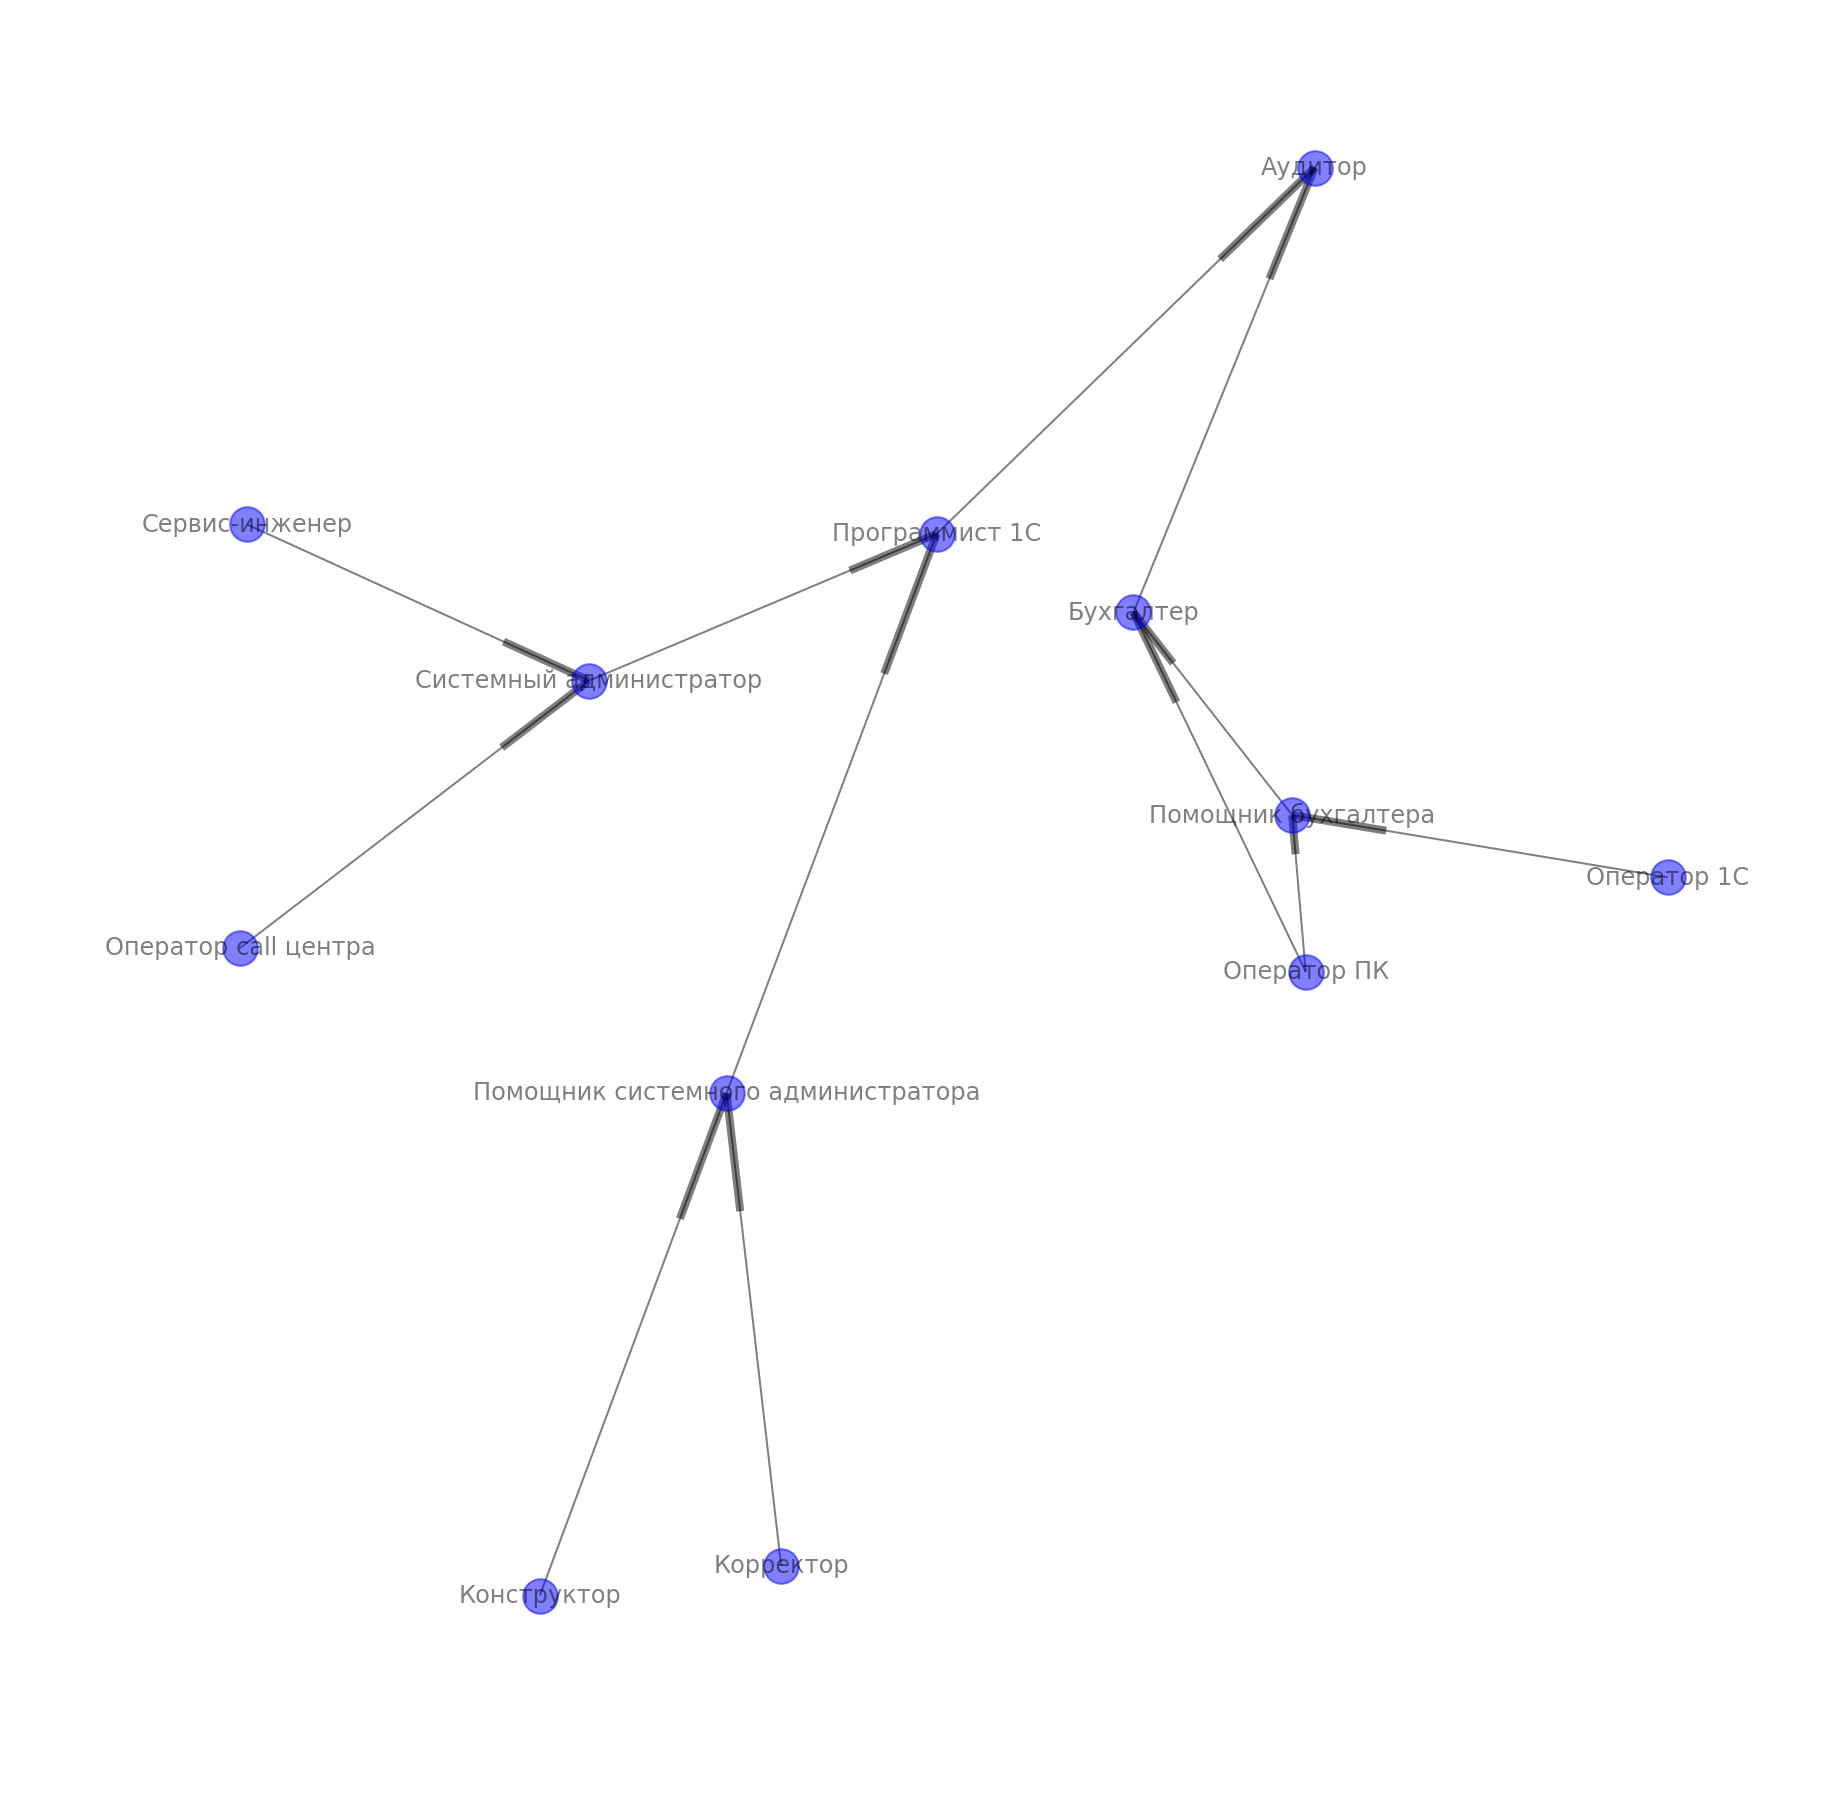

In [959]:
draw_path("Аудитор")

# Ок, сервис, я журналист. Кем я буду дальше?

In [1419]:
draw('Журналист')

In [940]:
our_skills = ['грамотная речь', 
              'самостоятельного поиска информации'] 
get_theme(our_skills)

'Журналист'

In [1444]:
draw('Журналист',  our_skills)

In [1443]:
cur_skills = ['грамотная речь', 'самостоятельного поиска информации'] 
_next = "Редактор"
recommend_vac(_next, cur_skills)

[('Редактор новостной ленты', 0.8600960373878479),
 ('Творческий редактор', 0.73613041639328),
 ('Журналист-редактор', 0.7246677875518799)]